In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display


In [5]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import mossbauer

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from os.path import join

from tqdm import tqdm

## data distance 17"

{'activity': 37000000.0}


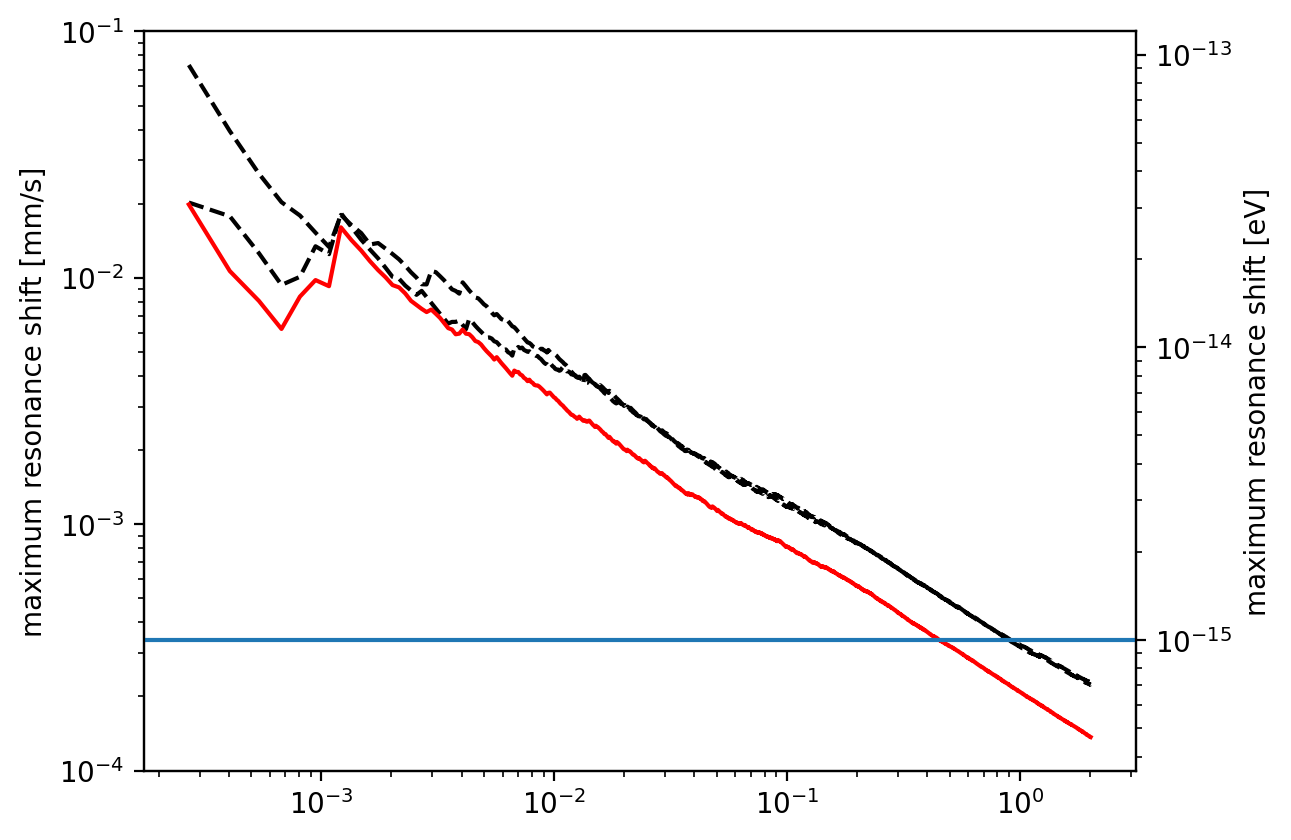

(4.533845944637101e-16, 2.417728402451219e-12)

In [9]:
from mossbauer.materials import CobaltRhodiumMatrix, AlphaIron, PotassiumFerrocyanide

source = CobaltRhodiumMatrix(activity=3.7e7)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
#absorber = AlphaIron(abundance=0.02, thickness_microns=10)
absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 1.75 * 25.4  # mm
PMT_distance = 17 * 25.4  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=99.0,
    detection_efficiency=0.66  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)




idx1=0
idx2=-1




idx1=0
idx2=-1
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname0 = '20230818_scan/FeCy_0.25_mms_2steps_0.6-17in.dat'
fname1 = '20230901_scan/FeCy_0.25_mms_2steps_0.6-17in.dat'

fnames = [fname0, fname1]
#fnames = [fname1]

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

dataframes = []
for fname in fnames:
    datatemp = pd.read_csv(join(datadir, fname))
    dataframes.append(datatemp)

    data = pd.concat(dataframes)
data = data[idx1:idx2]
datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

minlen = min(len(datav1['count']),len(datav2['count']))

datav1 = datav1[:minlen]
datav2 = datav2[:minlen]
    

    
sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]
sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]

n = datav1.reset_index().index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)

dt = datav1['DAQ_time'][1]/3600/24
time = n*dt


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14e3, 'r',label = 'diff')
ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
ax.set_ylim(1e-4,1e-1)
ax2.set_ylabel('maximum resonance shift [eV]')


ax2.axhline(1e-15)

plt.show()



time_old  = time
dEmin_diff_old = dEmin_diff

mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3, 4.4e-9/np.sqrt(40*23*3600)

# data distance 7''

### first plot spectrum, estimate noise

total rate = 491.43, noise rate = 279.84, signal rate = 211.58


array([4.66308876e+00, 1.07443871e-02, 2.59014092e+01, 6.68045270e+02,
       6.12698705e+01])

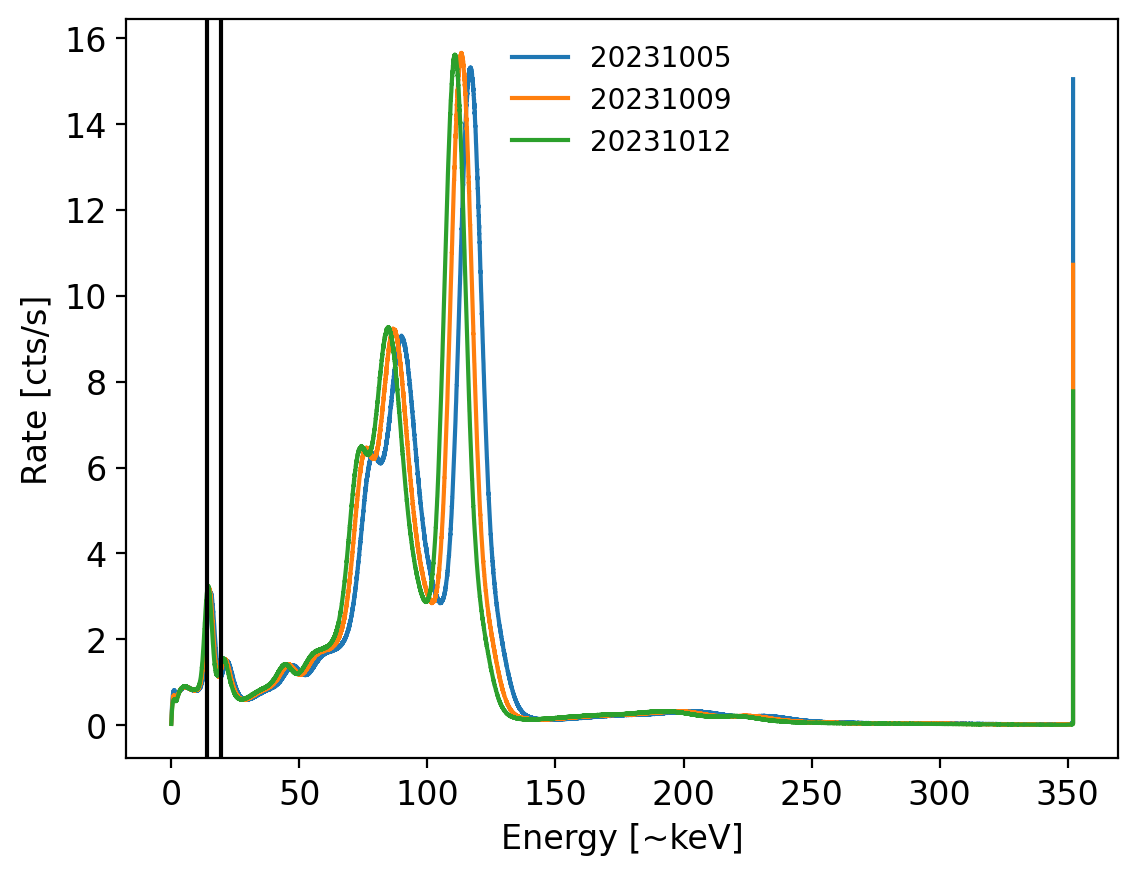

In [26]:
datadir = '/home/mossbauer/Data/mossbauer_data/'

fname0 = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in_avghist_0.365Hz_Ch1.dat'
fname1 = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in_avghist_0.365Hz_Ch1.dat'
fname2 = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in_avghist_0.365Hz_Ch1.dat'
fname3 = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in_avghist_0.365Hz_Ch1.dat'

fnames = [fname0,fname1,fname2]
#fnames = [fname0]

idx1 = 450
idx2 = 900

skim1 = 650
skim2 = 900

def func_tot(x, a, b,c, x0, sigma):
    return a+ b*x + c*np.exp(-(x-x0)**2/(2*sigma**2))

def func_noise(x, a, b):
    return a+ b*x

hist_time = 11.6

for fname in fnames:
    datahist = pd.read_csv(join(datadir, fname))
    ydata = datahist.iloc[:,0].values
    xdata = np.array(datahist.index.values,dtype = float)
    popt, pcov = curve_fit(func_tot, xdata[idx1:idx2], ydata[idx1:idx2],bounds=([1,0.0001,1,500,10], [20, 0.1, 100,900,500]))
    
    plt.plot(xdata*14.4/670, ydata/hist_time, label = fname[:8])
    #plt.plot(xdata[skim1:skim2]*14.4/670, func_tot(xdata[skim1:skim2], *popt)/hist_time, 'r--')
    #plt.plot(xdata[skim1:skim2]*14.4/670, func_noise(xdata[skim1:skim2], *popt[:2])/hist_time, 'r--')
    
    
    
    noise = func_noise(xdata[skim1:skim2], *popt[:2]).sum()/hist_time
    total = ydata[skim1:skim2].sum()/hist_time
    signal  = total-noise
    
    


print('total rate = {:.2f}, noise rate = {:.2f}, signal rate = {:.2f}'.format(total, noise, signal) )
plt.legend(frameon=False)
#popt = [7, 0.01,20,720,50]
#plt.plot(xdata, func(xdata, *popt), 'r-')
plt.axvline(skim1*14.4/670,color  = 'k')
plt.axvline(skim2*14.4/670,color  = 'k')
#plt.axvline(14.4,color  = 'r')
#plt.ylim(0,4)
#plt.xlim(0,150)
#plt.xlim(0,30)
plt.xlabel('Energy [~keV]')
plt.ylabel('Rate [cts/s]')
popt

In [27]:
total

491.4251460441672

In [28]:
from mossbauer.materials import CobaltRhodiumMatrix, AlphaIron, PotassiumFerrocyanide

source = CobaltRhodiumMatrix(activity=3.7e7)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 1.75 * 25.4  # mm
PMT_distance = 7 * 25.4  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=320,
    detection_efficiency=0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)

#with Si drift detector and 50mCi source, and Fe57:

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)




#with Si drift detector and 50mCi:
source2 = CobaltRhodiumMatrix()# default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
source2.total_activity = 100e-3* 3.7e10 *0.0916
absorber = PotassiumFerrocyanide()

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*30*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet_hotsource = mossbauer.MossbauerMeasurement(
    source2,
    absorber,
    measurement_parameters
)



#with Si drift detector hotsource and and Fe57 absorber:

pos = np.array([-5.48, -3.25, -1.01, 0.66, 2.90, 5.13])  # from Violet and Pipcorn 1971
pos = pos - np.mean(pos)
split_ratio = (3, 2, 1, 1, 2, 3)
offset = 0
Eres = pos + offset
natural_linewidth = 4.55e-9  # eV
source_activity = 3.7e10 * 100e-3  # Hz
mossbauer_relative_intensity = 0.0916
source3 = dict(
    Eres=Eres,
    transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=mossbauer.E_to_vel(natural_linewidth),
    total_activity=mossbauer_relative_intensity * source_activity
)


absorber2 = AlphaIron(abundance = 1, thickness_microns = 0.360)

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*30*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet_hotsource_Fe57 = mossbauer.MossbauerMeasurement(
    source3,
    absorber2,
    measurement_parameters
)


{'activity': 37000000.0}
{}
0.0180871353675058


In [29]:
absorber2.thickness_normalized, absorber.thickness_normalized

(5.6664, 1.95)

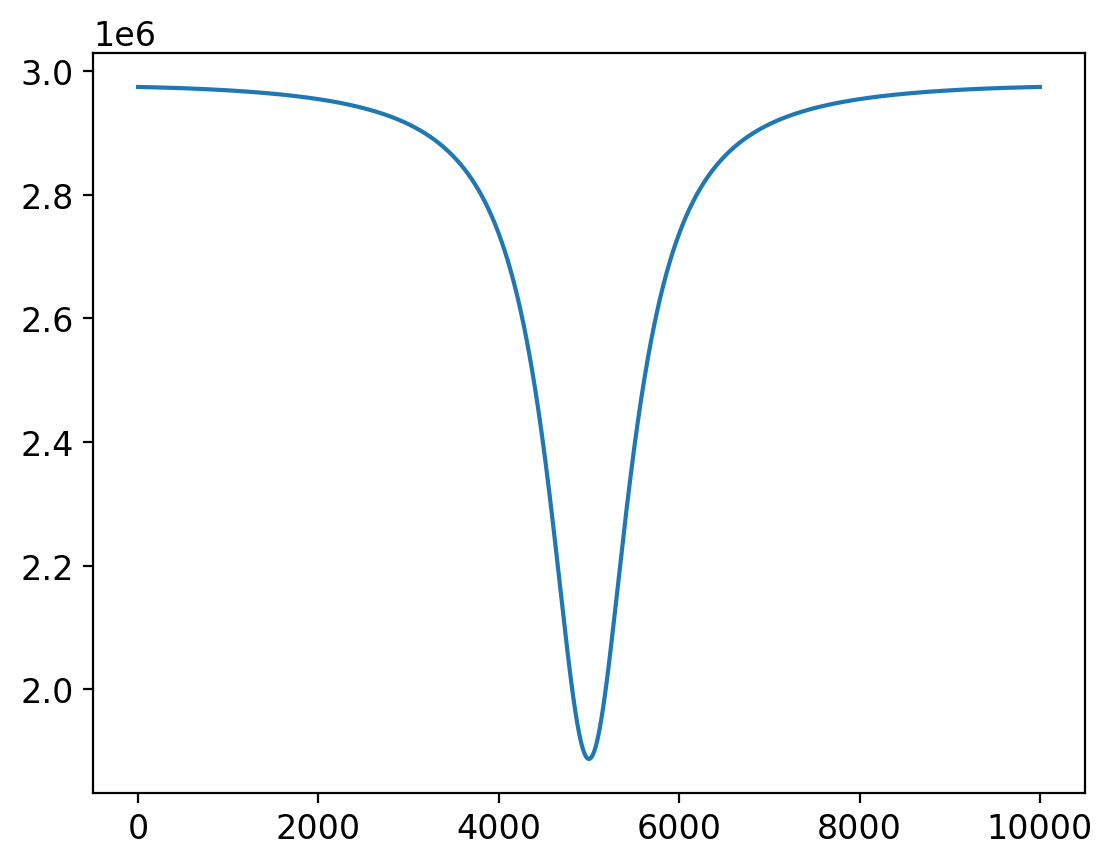

In [30]:
plt.plot(moss_siDet_hotsource_Fe57.transmitted_spectrum(vels))
#vels

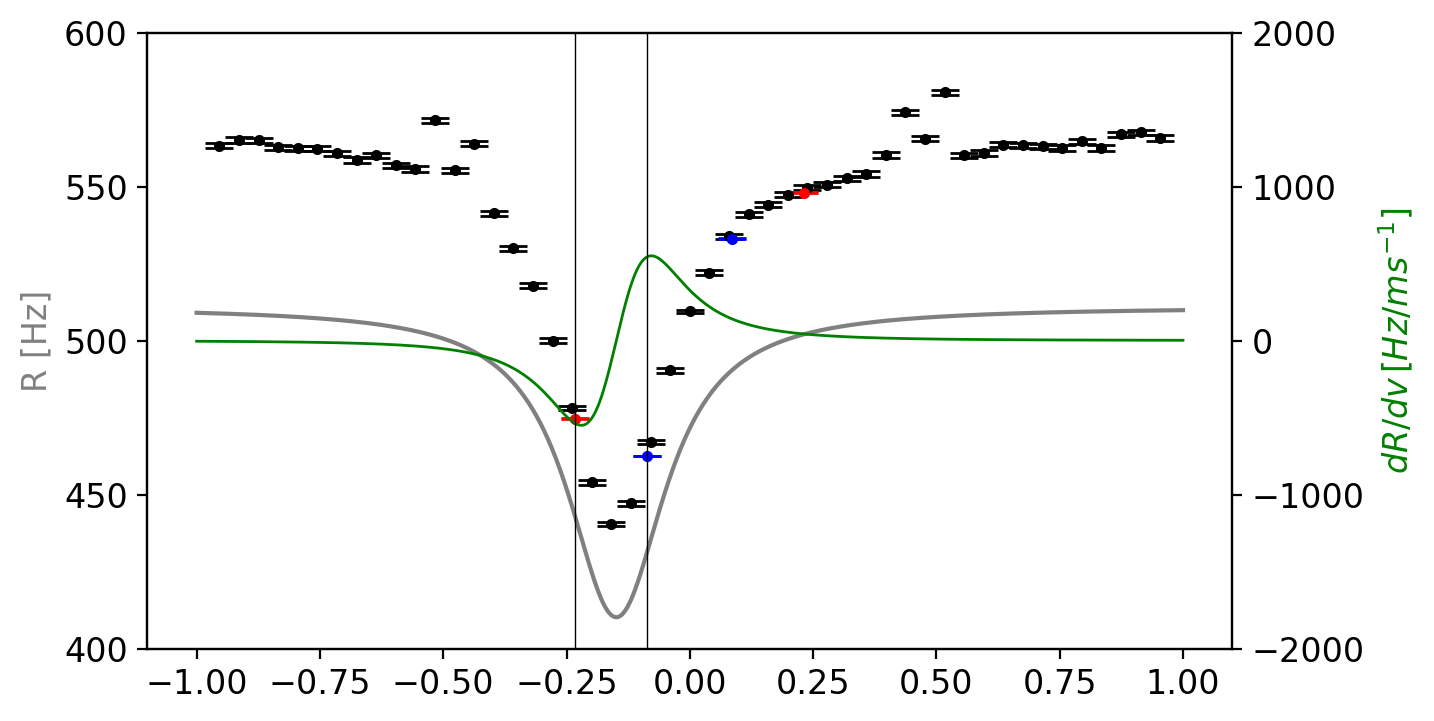

In [31]:
idx1=0
idx2=-1

## Data

fig, ax = plt.subplots(1, 1, figsize = (7,4))
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)



ax2 =ax.twinx()

vel = np.linspace(-1, 1, 1000)
dndv = moss.transmitted_spectrum_derivative(vel)

ax.plot(vel, moss.transmitted_spectrum(vel),color = 'gray')  # NOTE: derivative doesn't work for multi-line spectra
ax2.plot(vel , moss.transmitted_spectrum_derivative(vel), color = 'g', linewidth = 1)


datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20231004_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
rates_m[data.index>0] -= 0.4
ax.errorbar(
    -data.index.values,
    rates_m,
    yerr=rates_m/np.sqrt(data['count']), 
    fmt='k.',
    capsize=5
)



fname = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']*1.01
rates_m[data.index>0] -= 0.4

ax.errorbar(
    -data.index.values[::3],
    rates_m[::3],
    yerr=rates_m[::3]/np.sqrt(data['count'][::3]), 
    fmt='r.',
    capsize=5
)

ax.errorbar(
    -data.index.values[1:-1],
    np.array(rates_m)[1:-1],
    yerr=np.array(rates_m)[1:-1]/np.sqrt(np.array(data['count'])[1:-1]), 
    fmt='b.',
    capsize=5
)


fname = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']*1.06
rates_m[data.index>0] -= 0.4
#plt.errorbar(
#    -data.index.values,
#    rates_m,
#    yerr=rates_m/np.sqrt(data['count']), 
#    fmt='g.',
#    capsize=5
#)



fname = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']*1.11
rates_m[data.index>0] -= 0.4
#plt.errorbar(
#    -data.index.values,
#    rates_m,
#    yerr=rates_m/np.sqrt(data['count']), 
#    fmt='k.',
#    capsize=5
#)


fname = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
rates_m[data.index>0] -= 0.4
#plt.errorbar(
#    -data.index.values,
#    rates_m,
#    yerr=rates_m/np.sqrt(data['count']), 
#    fmt='k.',
#    capsize=5
#)

v1 = -0.2321399999999999
v2 = -0.08586

plt.axvline(v1,color = 'k', linewidth = 0.5)
plt.axvline(v2,color = 'k', linewidth = 0.5)
ax.set_ylabel('R [Hz]',color = 'gray')
ax2.set_ylabel('$dR/dv \, [Hz/ms^{-1}]$', color = 'g')
ax.set_ylim(400,600)
ax2.set_ylim(-2000,2000)
ax.set_yticks([400,450,500,550,600])
ax2.set_yticks([-2000,-1000,0,1000,2000])

#mossbauer.add_energy_axis(ax)
plt.show()

In [20]:
 data.index.values[1:-1], np.array(rates_m)[1:-1],np.array(data['count'])[1:-1]

(array([-0.08586,  0.08586]),
 array([481.41024495, 438.99977061]),
 array([13757635., 12557069.]))

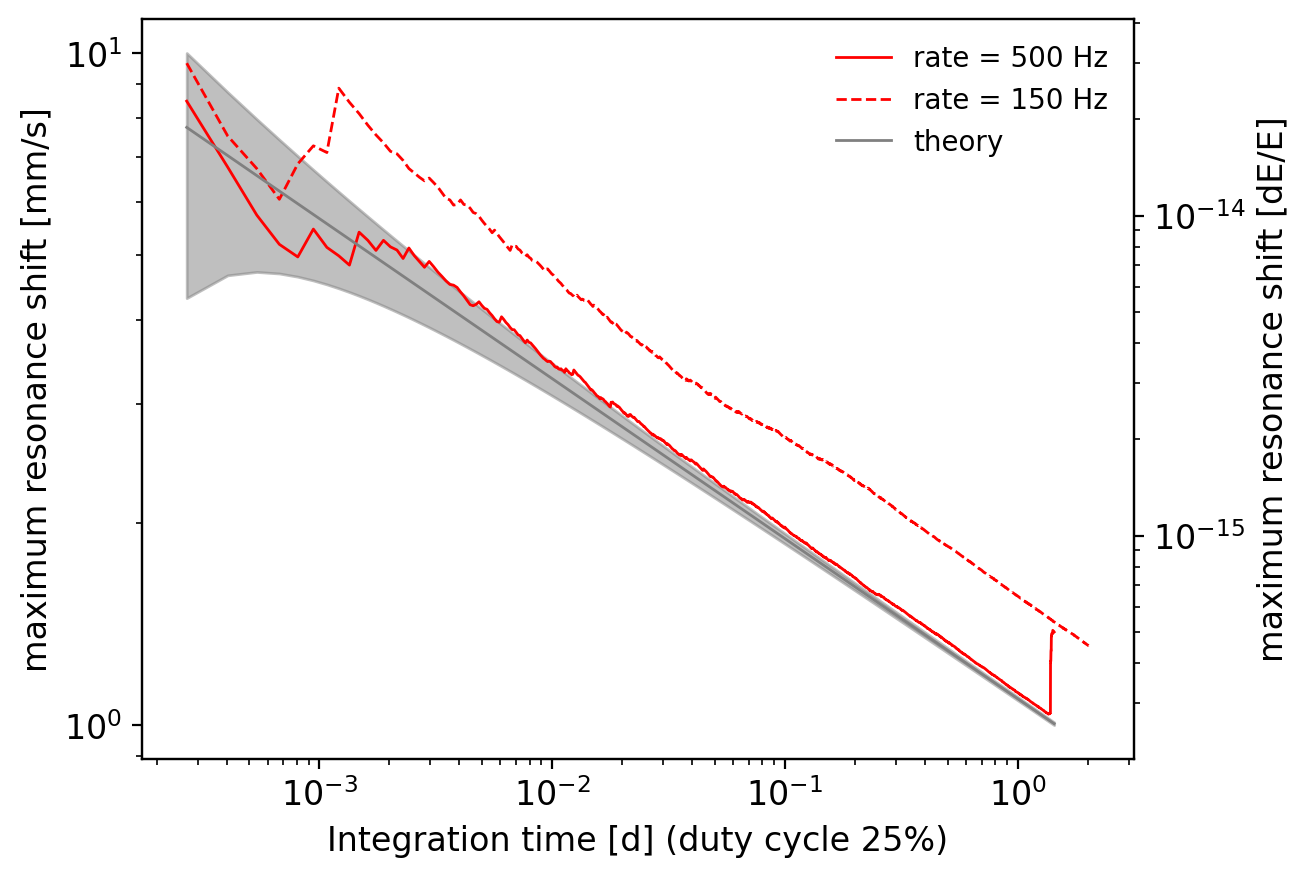

4.999256380646463e-16

In [32]:
idx1=0
idx2=-1

fname0 = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname1 = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname2 = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname3 = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'

fnames = [fname0, fname1,fname2,fname3]
#fnames = [fname3]

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

dataframes = []
for fname in fnames:
    datatemp = pd.read_csv(join(datadir, fname))
    dataframes.append(datatemp)

data = pd.concat(dataframes)
data = data[idx1:idx2]
datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

minlen = min(len(datav1['count']),len(datav2['count']))

datav1 = datav1[:minlen]
datav2 = datav2[:minlen]
    

    
sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]
sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]

n = datav1.reset_index().index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)

dt = datav1['DAQ_time'][1]/3600/24
time = n*dt
time_integration = n*datav1['DAQ_time'][1]


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


#ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14.4e3, 'r',linewidth = 1,label = 'rate = 500 Hz')
ax2.loglog(time_old, mossbauer.vel_to_E(dEmin_diff_old)/14.4e3, 'r--',linewidth = 1 ,label = 'rate = 150 Hz')

R1 = moss.transmitted_spectrum(v1)
R2 = moss.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_integration, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3

ax2.loglog(time, theory, 'gray', linewidth =1 , label = 'theory')
plt.fill_between(time, theory*(1-1/np.sqrt(n)), theory*(1+1/np.sqrt(n)), color='gray',alpha = 0.5)




#Expected improvements:





ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
#ax2.set_ylim(1e-16,3e-14)
ax2.set_ylabel('maximum resonance shift [dE/E]')





#ax2.axhline(3.55e-16)
plt.legend(loc = 'best',frameon=False)
ax.set_xlabel('Integration time [d] (duty cycle 25%)')
plt.show()


mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3





In [22]:
datav1['DAQ_time'][1]
R1/1e6
#2.3054633659259483e-16*14.4e3

0.0004426559563036567

dt

current sensitivity: 3.1030e-16


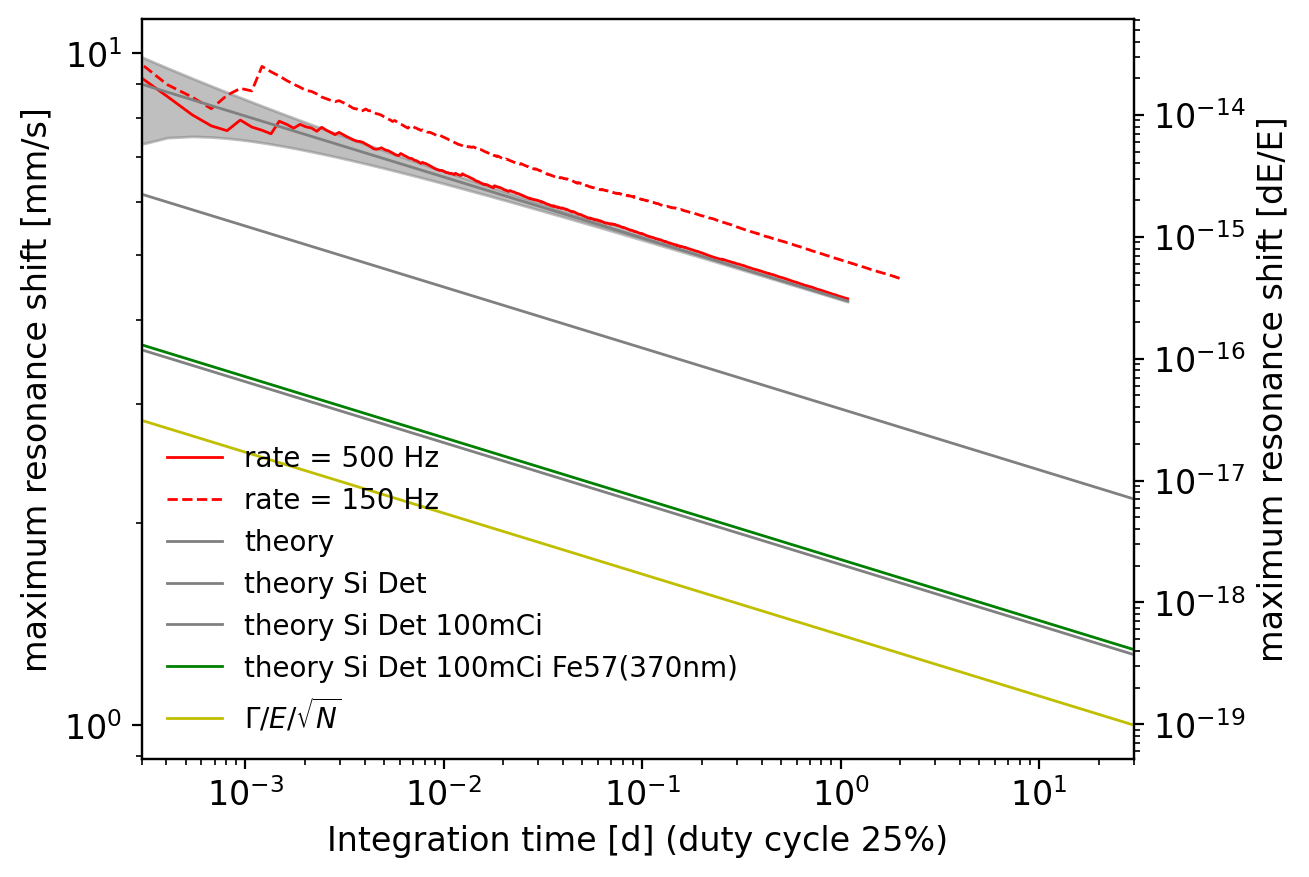

4.110352543131885e-19

In [25]:
idx1=0
idx2=-1

fname0 = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname1 = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname2 = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
#fname3 = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'

fnames = [fname0, fname1,fname2]
#fnames = [fname2]

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

dataframes = []
for fname in fnames:
    datatemp = pd.read_csv(join(datadir, fname))
    dataframes.append(datatemp)

data = pd.concat(dataframes)
data = data[idx1:idx2]
datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

minlen = min(len(datav1['count']),len(datav2['count']))

datav1 = datav1[:minlen]
datav2 = datav2[:minlen]
    

    
sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]
sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]

n = datav1.reset_index().index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)

dt = datav1['DAQ_time'][1]/3600/24
time = n*dt
time_integration =n*datav1['DAQ_time'][1]
time_theory = np.linspace(10,30*24*3600)


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


#ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14.4e3, 'r',linewidth = 1,label = 'rate = 500 Hz')
ax2.loglog(time_old, mossbauer.vel_to_E(dEmin_diff_old)/14.4e3, 'r--',linewidth = 1 ,label = 'rate = 150 Hz')

R1 = moss.transmitted_spectrum(v1)
R2 = moss.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_integration, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3

ax2.loglog(time, theory, 'gray', linewidth =1 , label = 'theory')
plt.fill_between(time, theory*(1-1/np.sqrt(n)), theory*(1+1/np.sqrt(n)), color='gray',alpha = 0.5)
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
print('current sensitivity: {:.4e}'.format(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3))


#Expected improvements:Si Det

dRdE_v1 = moss_siDet.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss_siDet.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
dRdE_diff = dRdE_v1 - dRdE_v2
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet.transmitted_spectrum(v1)
R2 = moss_siDet.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'gray', linewidth =1 , label = 'theory Si Det')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3


#Hot source

dRdE_v1 = moss_siDet_hotsource.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss_siDet_hotsource.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2
dRdE_diff_old = dRdE_diff 
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet_hotsource.transmitted_spectrum(v1)
R2 = moss_siDet_hotsource.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'gray', linewidth =1 , label = 'theory Si Det 100mCi')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3


#SI det Hot source Fe57
v1 = -0.1
v2 = 0.1
dv = 0.01

dRdE_v1 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v1-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v1+dv/2))/dv
dRdE_v2 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v2-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v2+dv/2))/dv
dRdE_diff = dRdE_v1 - dRdE_v2
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet_hotsource_Fe57.transmitted_spectrum(v1)
R2 = moss_siDet_hotsource_Fe57.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'g', linewidth =1 , label = 'theory Si Det 100mCi Fe57(370nm)')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
ax2.loglog(time_theory/24/3600, 5e-9/14.4e3/np.sqrt(time_theory*(R1+R2)), 'y', linewidth =1 , label = '$\Gamma/E/\sqrt{N}$')



ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
#ax2.set_ylim(1e-19,3e-14)
ax.set_xlim(3e-4,3e1)
ax2.set_ylabel('maximum resonance shift [dE/E]')





#ax2.axhline(3.55e-16)
plt.legend(loc = 'best',frameon=False)
ax.set_xlabel('Integration time [d] (duty cycle 25%)')
plt.show()


theory[-1]#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3



In [922]:
mossbauer.vel_to_E(1/dRdE_diff) , 1/(dRdE_diff*dv/mossbauer.vel_to_E(dv))

(4.36020265759432e-15, 4.36020265759432e-15)

In [924]:
mossbauer.vel_to_E(1/dRdE_diff)*(R1+R2)/5e-9

4.165253588442957

In [934]:
theory[-1]/(5e-9/14.4e3/np.sqrt(time_theory[-1]*(R1+R2)))

4.165253588442957

Text(0.5, 0, '')

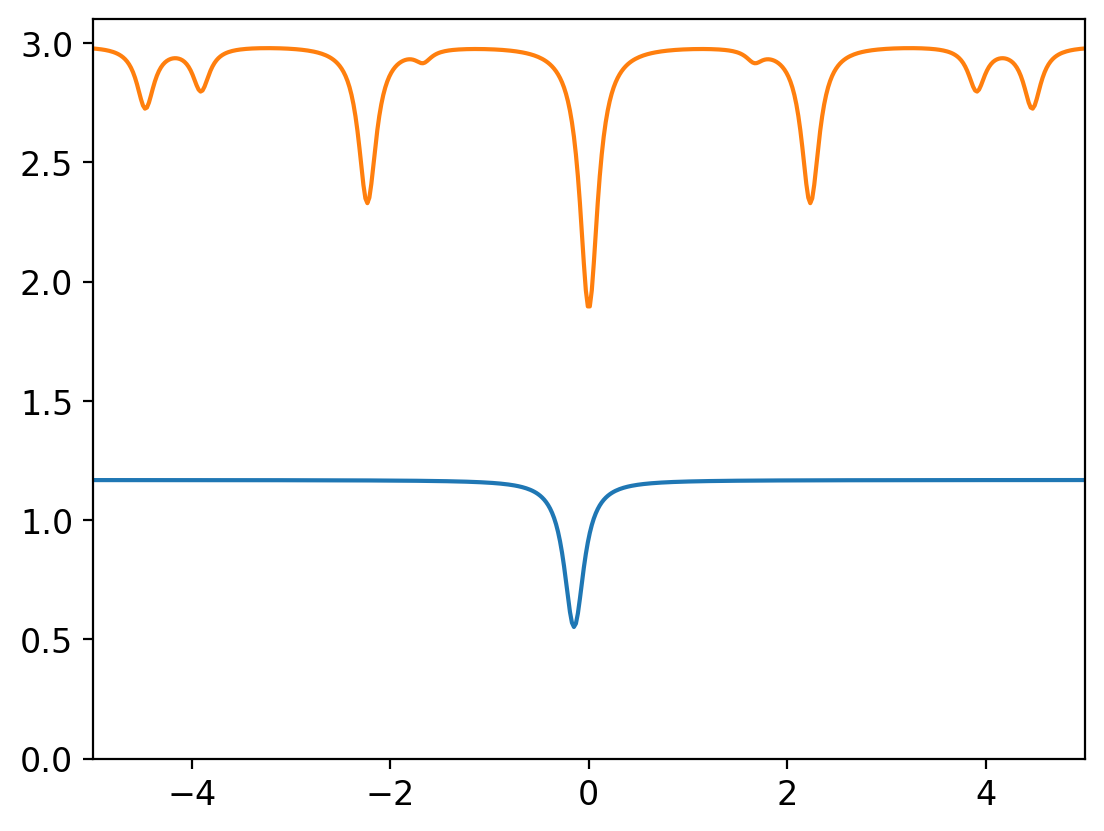

In [911]:
vels2 = np.linspace(-10,10,1000)
#plt.plot(vels2, moss.transmitted_spectrum(vels2)/1000)
#plt.plot(vels2, moss_siDet.transmitted_spectrum(vels2)/1000)
plt.plot(vels2, moss_siDet_hotsource.transmitted_spectrum(vels2)/1e6)
plt.plot(vels2,moss_siDet_hotsource_Fe57.transmitted_spectrum(vels2)/1e6)


#plt.plot(v1,moss_siDet_hotsource_Fe57.transmitted_spectrum(v1),'r.', markersize = 10)

#plt.yscale('log')
plt.xlim(-5,5)
plt.ylim(0,3.1)

plt.xlabel('')

In [881]:
d1 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v1-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v1+dv/2))/dv
d2 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v2-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v2+dv/2))/dv

In [882]:
dRdE_diff/dRdE_diff_old 


-1.6601439018214306

You can also look at the info of the source and absorber alone

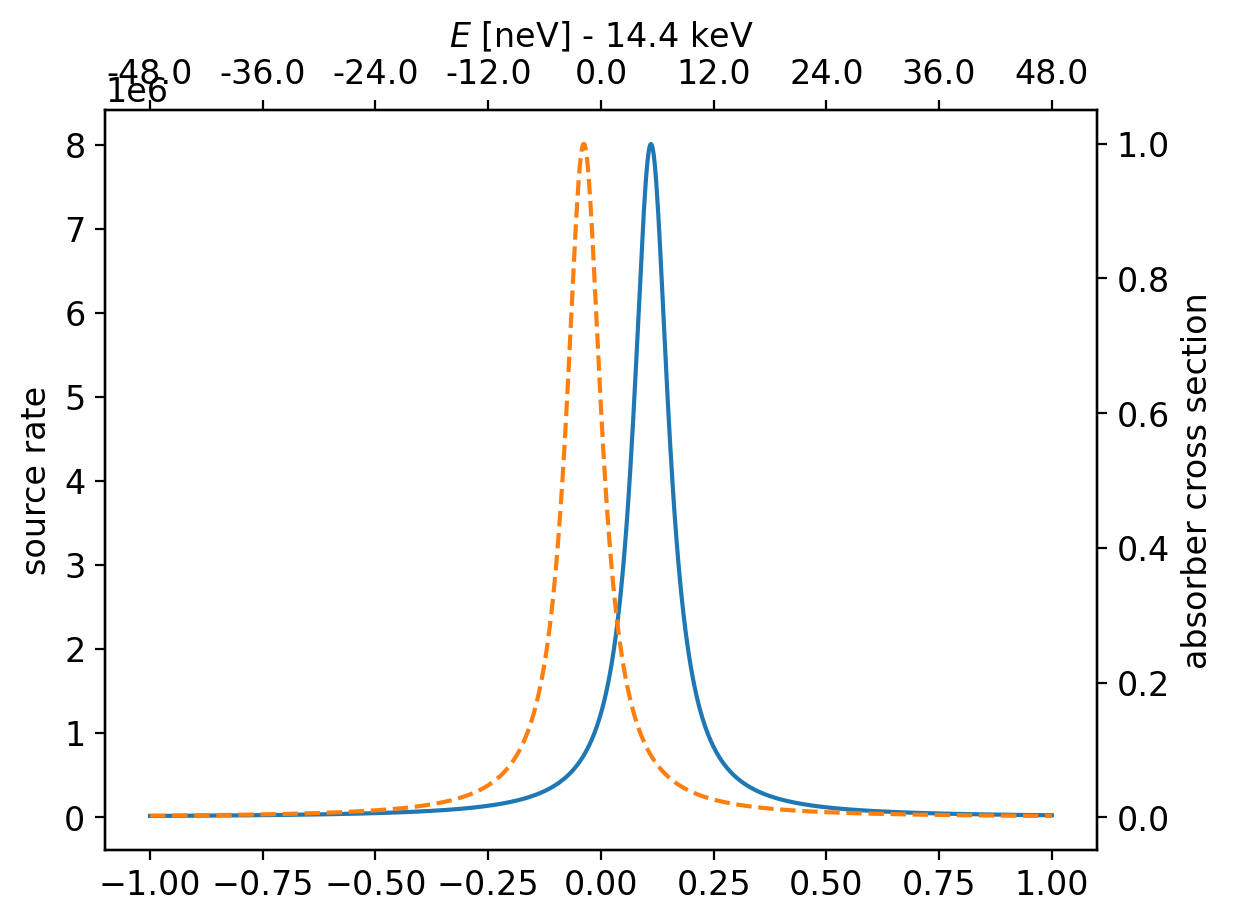

In [883]:
fig, ax = plt.subplots(1, 1)
plt.plot(vel, source.spectrum(vel))
plt.ylabel('source rate')
ax2 = ax.twinx()
plt.plot(vel, absorber.cross_section(vel), 'C1--')
plt.ylabel('absorber cross section')
plt.xlabel('vel [mm/s]')
mossbauer.add_energy_axis(ax)
plt.show()

### Check deltaEmin as a function of measurement velocity

In [884]:
mossbauer_relative_intensity = 0.0916
source_recoilless_fraction = 1.0
source_activity_Hz = 3.7e10 * 0.1  # 100 mCi

acquisition_time =  0.1 * 24 * 31  # 1 month


### source parameters
source_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    total_activity=source_activity_Hz * mossbauer_relative_intensity * source_recoilless_fraction
)


### absorber parameters
recoilless_fraction_A = 1.
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
absorber_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    thickness_normalized=t_mgcm2 * absorption_coefficient * recoilless_fraction_A
)

### measurement parameters
PMT_OD = 2 * 2.54  # cm
PMT_distance = 10  # cm
solid_angle_fraction = (PMT_OD / PMT_distance)**2.0 / 16
measurement_parameters = dict(
    acquisition_time=acquisition_time,
    solid_angle_fraction=solid_angle_fraction,
    detection_efficiency=1.0
)

moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

In [885]:
vels = moss.source.linewidth*np.logspace(-6, 2, 10000)
slope_vel, slope_rate, vnew = moss.get_deltaEmin_full(return_vels=True)
rates = moss.transmitted_spectrum(vels)

AttributeError: 'MossbauerMeasurement' object has no attribute 'get_deltaEmin_full'

NameError: name 'vnew' is not defined

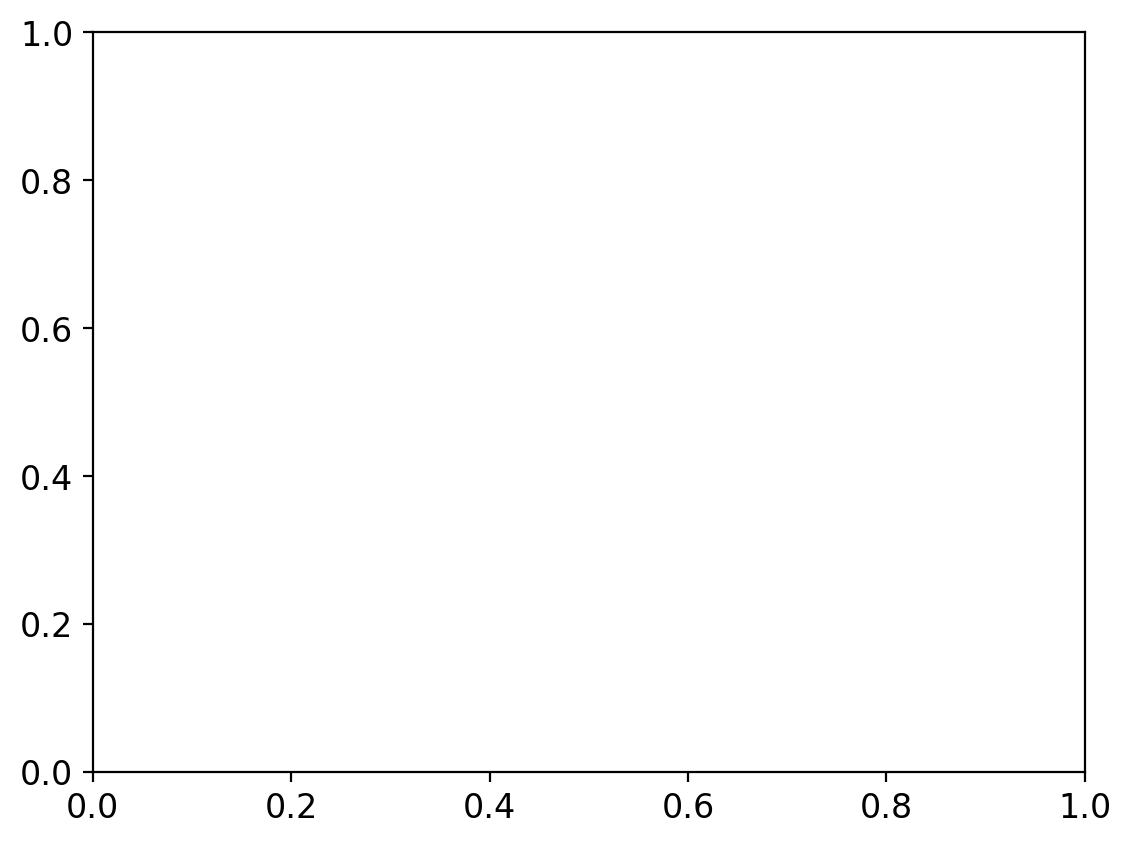

In [886]:
fig, ax = plt.subplots()
plt.plot(vels/mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth), mossbauer.vel_to_E(vnew), color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measurement Energy [$E/\Gamma_\mathrm{nat}$]')
plt.ylabel('$\delta E_\mathrm{min}/E$')

ax2 = ax.twinx()
ax2.grid(False)
plt.plot(vels/mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth), rates, linestyle='--', color='tomato')
plt.ylabel('Event Rate [Hz]')
change_axis_color(ax2, 'tomato')
ax2.spines['right'].set_color('tomato')
plt.xlim([1e-5, 1e1])


ax3 = ax.twiny()
plt.plot(vels, mossbauer.vel_to_E(vnew)/14.4e3, color='k')
plt.xscale('log')
xrange = np.array(ax.get_xlim())
ax3.set_xlim(xrange*mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth))
ax3.grid(False)
plt.xlabel('Velocity for $^{57}$Fe [mm/s]')

if False:
    plt.savefig('plots/sensitivity_fvs_velocity_closed_form_only.png', dpi=200)
plt.show()

### Thickness broadening

In [887]:
ts = np.logspace(-2, 2, 100)
deltaE_opt = np.zeros_like(ts)

for i, t in enumerate(tqdm(ts)):
    moss_siDet_hotsource.absorber.thickness_normalized = t
    # the linear approximation works pretty well for this, but doing full just to check
    #ans = moss.get_deltaEmin_linear()#vels=np.logspace(-4, 0, 1000), acquisition_time=acquisition_time)
    ans = moss_siDet_hotsource.get_deltaEmin_full_old()
    deltaE_opt[i] = mossbauer.vel_to_E(ans[2])

moss.absorber.thickness_normalized = t_mgcm2 * absorption_coefficient * recoilless_fraction_A

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


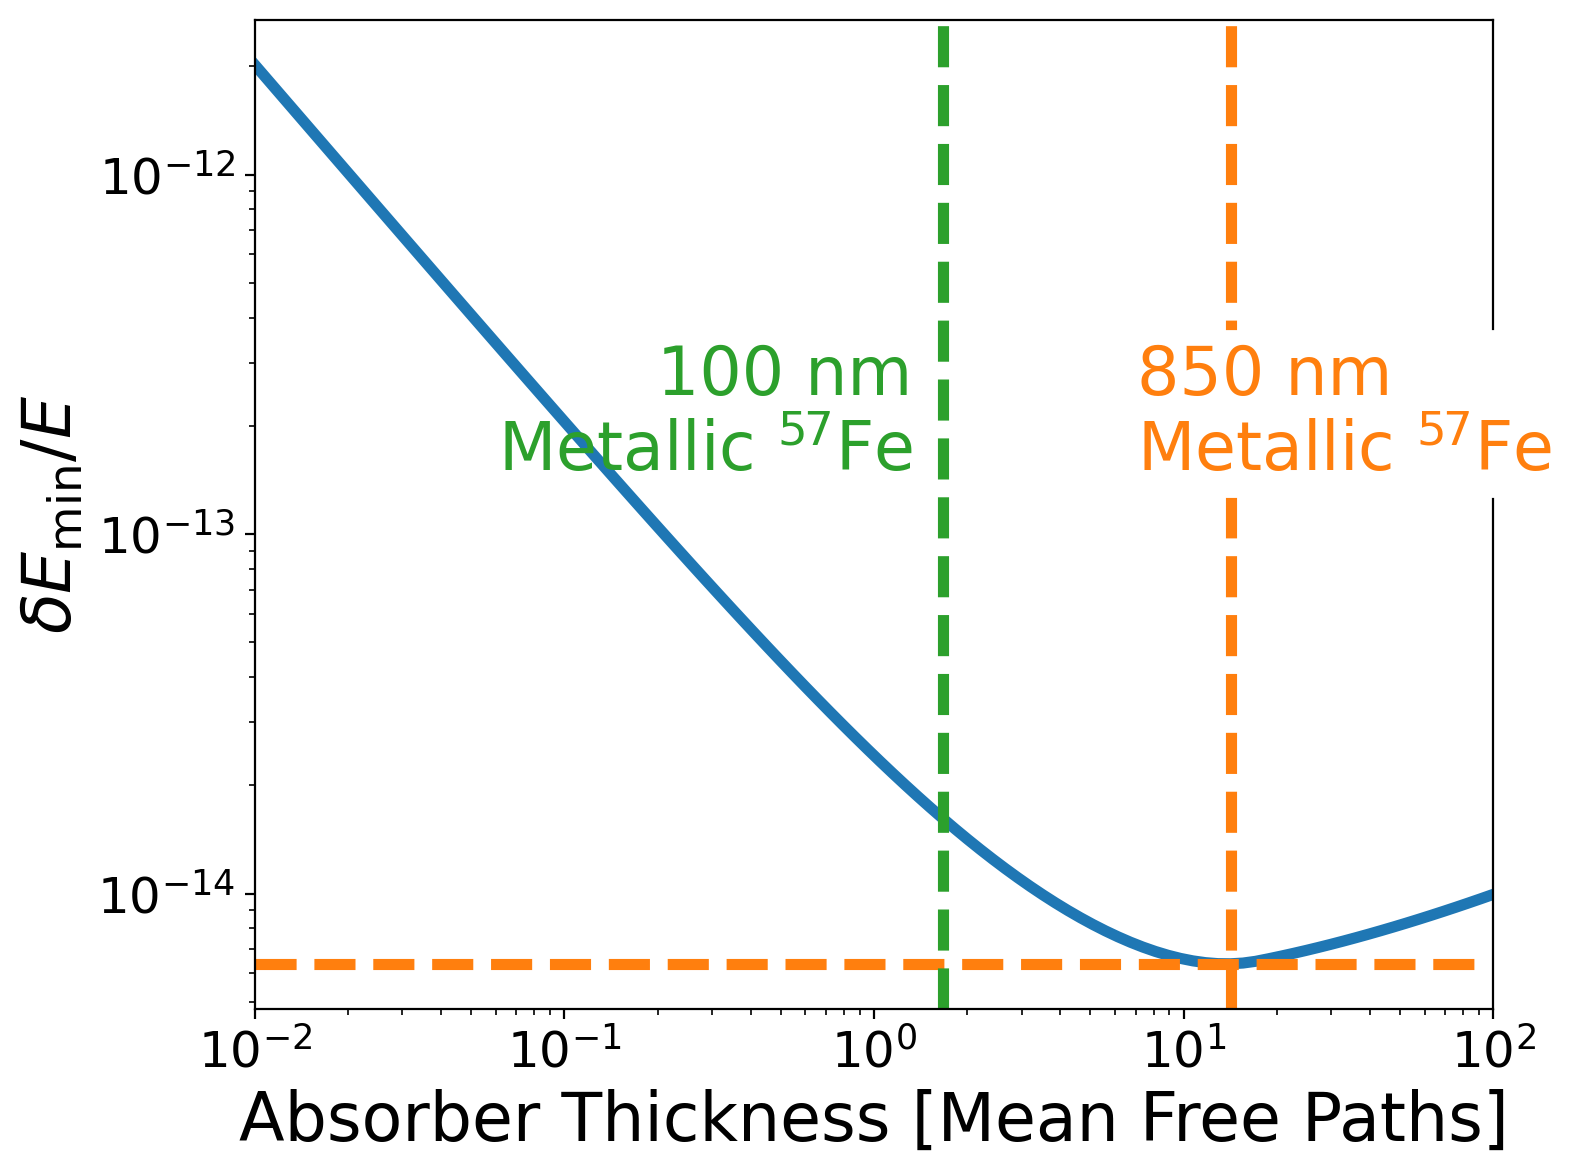

In [888]:
t_exp = (100./48)*0.8
#plt.plot(ts, deltaE, lw=3)
fig, ax = plt.subplots(figsize=(8, 6))
fsize = 24
plt.plot(ts, deltaE_opt, lw=4)
tmin = ts[np.argmin(deltaE_opt)]
plt.axvline(tmin, color='C1', linestyle='--', lw=4)
plt.axhline(deltaE_opt.min(), color='C1', linestyle='--', lw=4)
plt.annotate('%d nm\nMetallic $^{57}$Fe' % (tmin * 48/.8), (tmin*0.5, 1.5e-13), color='C1', fontsize=fsize, bbox=dict(color='w'))
plt.axvline(t_exp, color='C2', linestyle='--', lw=4)
plt.annotate('100 nm\nMetallic $^{57}$Fe' , (t_exp*0.8, 1.5e-13), color='C2', ha='right', fontsize=fsize)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Absorber Thickness [Mean Free Paths]', fontsize=fsize)
plt.ylabel(r'$\delta E_\mathrm{min}/E$', fontsize=fsize)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.xlim([0.01, 100])
plt.tight_layout()
#if False:
#    plt.savefig('plots/effective_absorber_thickness_vs_sensitivity.png')
plt.show()

### Sensitivity

The sensitivity calculation is sequestered in `physics.py` because its a bit of a black box how to go from $\delta E$ to this space. I've mostly filed all this under the title "physics" and left it to Surjeet. In my opinion it anyway makes the most sense to compare sensitivities in terms of $\delta E$ directly, as this is our actual experimental observable. And this calculation also comes from the above `MossbauerMeasurement.get_deltaEmin_full()`.

But for proposals and stuff, I took the function below from Surjeet.

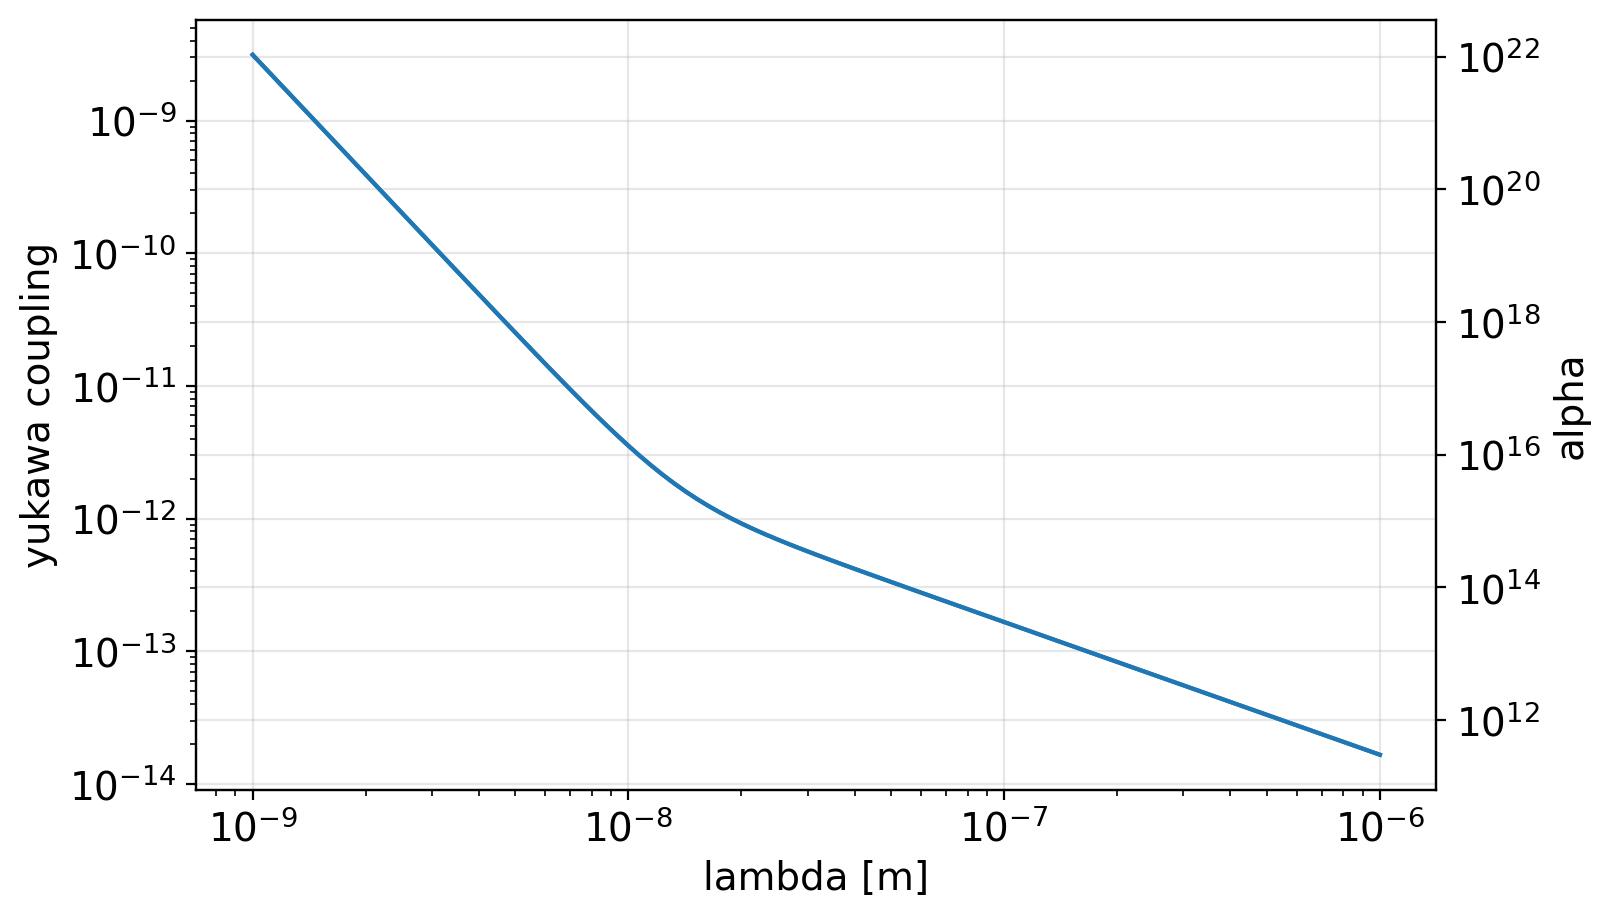

In [16]:
deltaEmin = mossbauer.vel_to_E(moss.get_deltaEmin_full()[2])  # actual experimental observable
r, (yuk, alpha) = moss.get_sensitivity(deltaEmin, 'down_quark')  # physics function from Surjeet

fig, ax = plt.subplots(1, 1)
plt.plot(r, yuk)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda [m]')
plt.ylabel('yukawa coupling')

ax2 = ax.twinx()
plt.yscale('log')
plt.ylabel('alpha')
plt.plot(r, alpha)

plt.show()